In [1]:
import numpy as np
from glob import glob
# import matplotlib as mpl
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import warnings
import scipy.signal as sig
import sys
import cmocean as cm
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle
import seawater as sw

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:


plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 20})

# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [3]:
path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

In [4]:
%%time
# chunks_new={'dayofyear':40}

tf=varf.temp.groupby("time_counter.dayofyear").mean()
# tf=tf.chunk(chunks=chunks_new);
tf=tf.compute();
tf=tf[:,1:-1,1:-1].compute()


CPU times: user 9.94 s, sys: 5.44 s, total: 15.4 s
Wall time: 47 s


In [5]:
chunks_new={'dayofyear':40}

%time
uf=varf.u.groupby("time_counter.dayofyear").mean()
uf=uf.chunk(chunks=chunks_new);
uf=uf.compute();


vf=varf.v.groupby("time_counter.dayofyear").mean()
vf=vf.chunk(chunks=chunks_new);
vf=vf.compute();


CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11 µs


In [6]:
day=150

In [7]:
dx=500

In [8]:
vfx=(0.5*(vf[:,1:,:]+vf[:,:-1,:]))[:,:,1:-1]
ufx=(0.5*(uf[:,:,1:]+uf[:,:,:-1]))[:,1:-1,:]

In [9]:
lonx,latx=varf.temp.nav_lon_rho.compute()[1:-1,1:-1],varf.temp.nav_lat_rho.compute()[1:-1,1:-1]

In [10]:
fo=sw.f(latx.data)

In [11]:
zeta_f=np.gradient(vfx[day],axis=1)/dx - np.gradient(ufx[day],axis=0)/dx
div_f=np.gradient(ufx[day],axis=1)/dx + np.gradient(vfx[day],axis=0)/dx


In [12]:
strain_f= np.sqrt(
    (np.gradient(ufx[day],axis=1)/dx - np.gradient(vfx[day],axis=0)/dx)**2 + 
    (np.gradient(vfx[day],axis=1)/dx + np.gradient(ufx[day],axis=0)/dx)**2)

In [13]:
latx.min().data,latx.max().data,lonx.min().data, lonx.max().data

(array(32.54691, dtype=float32),
 array(40.72058, dtype=float32),
 array(-128.97618, dtype=float32),
 array(-119.910934, dtype=float32))

/homes/metogra/iufarias/miniconda3/envs/test/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'projection'
  result = super().contourf(*args, **kwargs)
/homes/metogra/iufarias/miniconda3/envs/test/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/homes/metogra/iufarias/miniconda3/envs/test/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


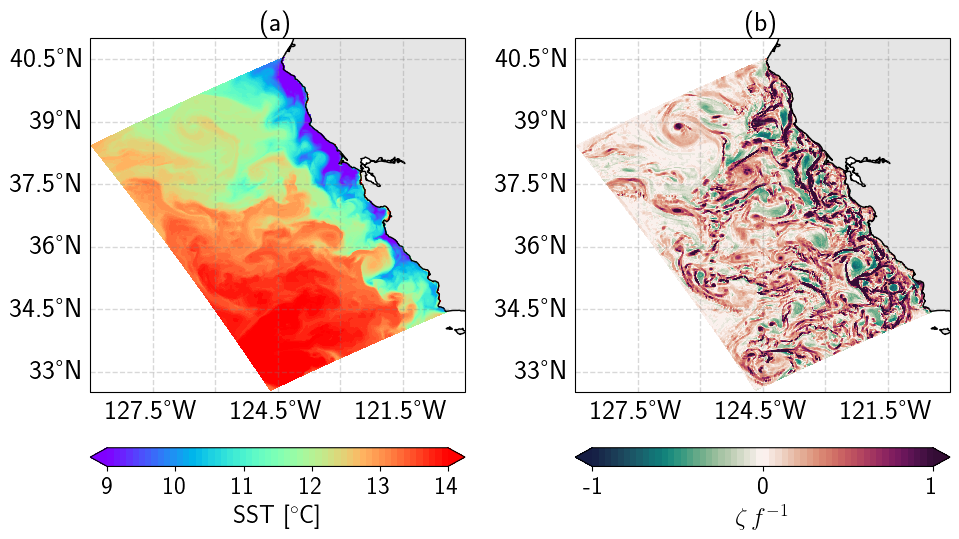

In [20]:
fig=plt.figure(figsize=(10, 10))

ax = fig.subplots(1,2, subplot_kw={'projection':ccrs.PlateCarree()})
ax = ax.ravel()

# ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

gl = ax[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.3,linestyle='--')


ax[0].set_extent([-129,-120,32.5,41], ccrs.PlateCarree())

ax[0].coastlines(resolution='10m')
ax[0].add_feature(cfeature.LAND.with_scale('10m'),color='gray',alpha=0.2)
# ax1.gridlines(draw_labels=True)
im=ax[0].contourf(lonx,latx,
            tf[day],levels=np.linspace(9,14,55),
                cmap='rainbow',extend='both',projection= ccrs.PlateCarree())
cb = fig.colorbar(im,fraction=0.08,orientation='horizontal',pad=0.06,ticks=[9,10,11,12,13,14])

cb.set_label(label=r'SST [$^{\circ}$C]', fontsize=18)
cb.ax.tick_params(labelsize='large')
cb.ax.set_xticklabels(['9','10','11','12','13','14'],fontsize=18)

gl.xlabels_top = 0
gl.ylabels_right = 0
# gl.xlabels_bottom= 0
# gl.ylabels_left=0
gl.xlabel_style = {'size': 20, 'color': 'black', 'rotation':0}
gl.ylabel_style = {'size': 20, 'color': 'black', 'rotation':0 }


# ax1.set_xticks([lonx.min(),lonx.max()], crs=ccrs.PlateCarree())
# ax1.set_yticks([latx.min(),latx.max()], crs=ccrs.PlateCarree())
ax[0].set_title(r'(a)',fontsize=20)


gl1 = ax[1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.3, linestyle='--')


ax[1].set_extent([-129,-120,32.5,41], ccrs.PlateCarree())

ax[1].coastlines(resolution='10m')
ax[1].add_feature(cfeature.LAND.with_scale('10m'),color='gray',alpha=0.2)
# ax1.gridlines(draw_labels=True)
im1=ax[1].contourf(lonx,latx,zeta_f/fo,levels=np.linspace(-1,1,55),extend='both',cmap=cm.cm.curl,projection=ccrs.PlateCarree())

cb1 = plt.colorbar(im1,fraction=0.08,orientation='horizontal',pad=0.06,ticks=[-1,0,1],label=[-1,0,1])
cb1.set_label(label=r'$\zeta\,f^{-1}$', fontsize=18)
cb1.ax.tick_params(labelsize='large')
cb1.ax.set_xticklabels(['-1','0','1'],fontsize=18)

gl1.xlabels_top = 0
gl1.ylabels_right = 0
# gl1.xlabels_bottom= 0
# gl1.ylabels_left=0
gl1.xlabel_style = {'size': 20, 'color': 'black', 'rotation':0 }
gl1.ylabel_style = {'size': 20, 'color': 'black', 'rotation':0 }

# cxx=ax[1].set_xticks(np.arange(-127.5,-120.5,3),  crs=ccrs.PlateCarree())
# ax[1].set_xticklabels(['127.5 W', '124.5 W', '121.5 W'],**hfont)
# ax[1].set_yticks([latx.min(),latx.max()], crs=ccrs.PlateCarree())
ax[1].set_title(r'(b)',fontsize=20)


plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/poster/SST+rossby.png',dpi=400,bbox_inches='tight')
